In [1]:
# %%sh
# sudo apt install fonts-cmu texlive-latex-extra cm-super dvipng
# mkdir out

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

'/usr/share/fonts/truetype/cmu/cmunrm.ttf'

In [3]:
def theoretical_bytes(s: pd.Series) -> int:
    dsize = dict(float16=2, float32=4)[s["dtype"]]
    if "sparq" in s.kernel:
        return dsize * s.n_head * (s.k1 * s.sequence_length + 2 * s.k2 * s.head_dim)
    return dsize * s.n_head * (2 * s.sequence_length * s.head_dim)

df = (pd.read_json("benchmarks.json")
    .pipe(lambda d: d.assign(
        duration=d.duration/d.batch_size,  # convert duration to per-query
        stderr_ratio=d.duration_stderr/d.duration,
        theoretical_bytes=d.apply(theoretical_bytes, axis=1),
        baseline=d.kernel.apply(lambda x: not ("sparq" in x or x == "attn-local")),
        device=d.device.apply(dict(ipu="ipu", cuda="gpu", cpu="cpu").__getitem__),
        device_name=d.device_name.apply(lambda n: {
            "M2000": "M2000",
            "NVIDIA A10G": "A10G",
            "NVIDIA A100-SXM4-40GB": "A100-40GB"
        }.get(n, n))
    ))
    .pipe(lambda d: d.assign(achieved_bandwidth=d.theoretical_bytes/d.duration))
    .groupby(["device_name", "sequence_length", "batch_size"])
        .apply(lambda d: d.assign(  # Speedup per batch size (not for best batch size)
            speedup=d[d.baseline].duration.min() / d.duration,
            theoretical_speedup=d[d.baseline].theoretical_bytes.min() / d.theoretical_bytes,
        ))
        .reset_index(drop=True)
    [["device", "device_name", "sequence_length", "batch_size",
      "kernel", "k1", "k2", "baseline", "theoretical_bytes", "theoretical_speedup",
      "duration", "stderr_ratio", "speedup", "achieved_bandwidth"]]
)
df.head()

,device,device_name,sequence_length,batch_size,kernel,k1,k2,baseline,theoretical_bytes,theoretical_speedup,duration,stderr_ratio,speedup,achieved_bandwidth
0,gpu,A100-40GB,2048,1,attn-torch,NaN,NaN,True,33554432.0,1.0,0.000095,0.001182,1.000000,3.549363e+11
1,gpu,A100-40GB,2048,1,attn-compiled,NaN,NaN,True,33554432.0,1.0,0.000156,0.001133,0.605066,2.147598e+11
2,gpu,A100-40GB,2048,1,attn-flash,NaN,NaN,True,33554432.0,1.0,0.000167,0.000706,0.567374,2.013815e+11
3,gpu,A100-40GB,2048,1,attn-math,NaN,NaN,True,33554432.0,1.0,0.000109,0.003623,0.869312,3.085502e+11
4,gpu,A100-40GB,2048,1,attn-mem-efficient,NaN,NaN,True,33554432.0,1.0,0.000143,0.000544,0.660787,2.345371e+11


# Tables

In [4]:
k1, k2 = 32, 64
sequence_length = 4096

batch_size = 64
print(f"GPU sequence_length={sequence_length}, batch_size={batch_size}, k1={k1}, k2={k2}")

display(df
    .pipe(lambda d: d[d.device == "gpu"])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "attn-mem-efficient"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[~d.kernel.isin(["sparq-attn-torch-oneK", "sparq-attn-compiled-oneK", "sparq-attn-torch"])])
    .pipe(lambda d: d[d.batch_size == batch_size])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pipe(lambda d: d.assign(result=d.apply(lambda x: f"{x.duration*1e6:.0f} us ({x.speedup:.2f})", axis=1)))
    .pipe(lambda d: d.assign(stderr_ratio=d.apply(lambda x: f"{x.stderr_ratio*100:.2f} %", axis=1)))
    .pivot_table(index=["kernel"], columns="device_name", values=["result", "speedup", "theoretical_speedup", "stderr_ratio"], aggfunc="first")
    .swaplevel(axis=1)
    .sort_values(("A100-40GB", "speedup"))
    .drop(columns=[("A100-40GB", "speedup"), ("A10G", "speedup")])
)

sequence_length = 16384
batch_size = 1
print(f"IPU sequence_length={sequence_length}, batch_size={batch_size}, k1={k1}, k2={k2}")

display(df
    .pipe(lambda d: d[d.device == "ipu"])
    .pipe(lambda d: d[d.kernel.isin(["attn-remote", "attn-local"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[d.batch_size == batch_size])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pipe(lambda d: d.assign(result=d.apply(lambda x: f"{x.duration*1e6:.0f} us ({x.speedup:.2f})", axis=1)))
    .pipe(lambda d: d.assign(stderr_ratio=d.apply(lambda x: f"{x.stderr_ratio*100:.2f} %", axis=1)))
    .pivot_table(index=["kernel"], values=["result", "speedup", "theoretical_speedup", "stderr_ratio"], aggfunc="first")
    .sort_values("speedup")
    .drop(columns="speedup")
)

GPU sequence_length=4096, batch_size=64, k1=32, k2=64


device_name,A100-40GB,A10G,A100-40GB,A10G,A100-40GB,A10G
,result,result,stderr_ratio,stderr_ratio,theoretical_speedup,theoretical_speedup
kernel,,,,,,
attn-mem-efficient,50 us (0.98),128 us (1.00),0.02 %,0.00 %,1.000000,1.000000
attn-torch,49 us (1.00),135 us (0.95),0.03 %,0.04 %,1.000000,1.000000
sparq-attn-triton-oneK,37 us (1.33),76 us (1.69),0.23 %,0.02 %,7.111111,7.111111
sparq-attn-compiled,32 us (1.53),71 us (1.80),0.02 %,0.03 %,7.111111,7.111111
sparq-attn-triton,16 us (3.10),28 us (4.52),0.03 %,0.02 %,7.111111,7.111111


IPU sequence_length=16384, batch_size=1, k1=32, k2=64


,result,stderr_ratio,theoretical_speedup
kernel,,,
attn-remote,40432 us (1.00),0.00 %,1.000000
sparq-attn,5278 us (7.66),0.00 %,7.757576
attn-local,134 us (302.34),0.00 %,1.000000


# Figures

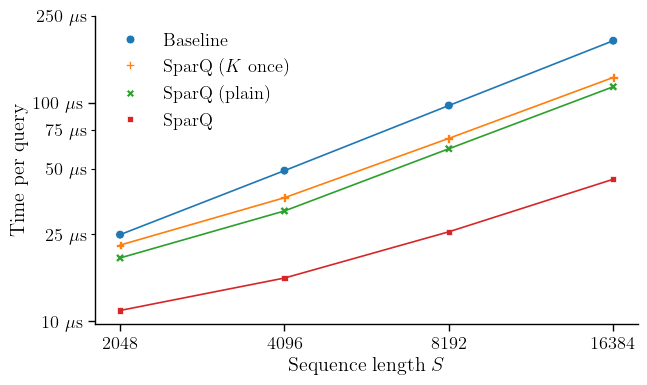

In [5]:
kernel_names = {
    "attn-torch": "Baseline",
    "sparq-attn-triton-oneK": "SparQ ($K$ once)",
    "sparq-attn-compiled": "SparQ (plain)",
    "sparq-attn-triton": "SparQ",
}
d = (df
    .pipe(lambda d: d[d.device_name == "A100-40GB"])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "sparq-attn-compiled", "sparq-attn-triton-oneK", "sparq-attn-triton"])])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch"]) | ((d.k1==32) & (d.k2==64))])
    .pipe(lambda d: d[d.batch_size == 64])
    .pipe(lambda d: d[d.sequence_length <= 16384])
    .pipe(lambda d: d.assign(kernel=d.kernel.apply(kernel_names.__getitem__)))
)
plt.figure(figsize=(7, 4))
ax = sns.scatterplot(data=d, y="duration", x="sequence_length", hue="kernel", hue_order=list(kernel_names.values()), style="kernel", s=40)
sns.lineplot(data=d, y="duration", x="sequence_length", hue="kernel", hue_order=list(kernel_names.values()), legend=False)
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_yscale("log")
ax.legend(frameon=False)
ax.yaxis.set_major_formatter(lambda x, _: f"{x*1e6:.0f} $\mu$s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x*1e6:.0f} $\mu$s")
ax.set_xlabel("Sequence length $S$")
ax.set_ylabel("Time per query")
ax.set_yticks([25e-6, 50e-6, 75e-6, 250e-6], minor=True)
# ax.tick_params(axis="both", which="minor", labelsize=11)
sns.despine(ax=ax)
plt.savefig(f"out/benchmark_a100_b64.pdf", bbox_inches="tight")

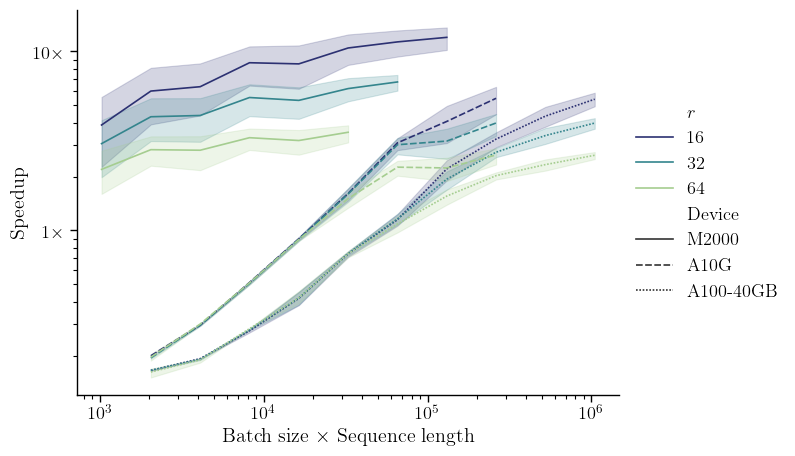

In [6]:
plt.figure(figsize=(7, 5))
ax = sns.lineplot(data=df
 .pipe(lambda d: d[d.kernel.isin(["sparq-attn", "sparq-attn-triton"])])
 .pipe(lambda d: d.assign(k1=d.k1.apply(int), k2=d.k2.apply(int), nelement=d.batch_size * d.sequence_length)),
    x="nelement", y="speedup", hue="k1", hue_norm=matplotlib.colors.LogNorm(),
    style="device_name", style_order=["M2000", "A10G", "A100-40GB"],
    palette="crest_r",
)
sns.despine(ax=ax)
ax.set_ylabel("Speedup")
ax.set_xlabel(r"Batch size $\times$ Sequence length")
ax.set_yscale("log")
ax.set_xscale("log")
ax.yaxis.set_major_formatter("${x:.0f}\\times$")
handles, labels = ax.get_legend_handles_labels()
labels[labels.index("k1")] = "$r$"
labels[labels.index("device_name")] = "Device"
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.savefig(f"out/benchmark_scaling.pdf", bbox_inches="tight");

# Graveyard

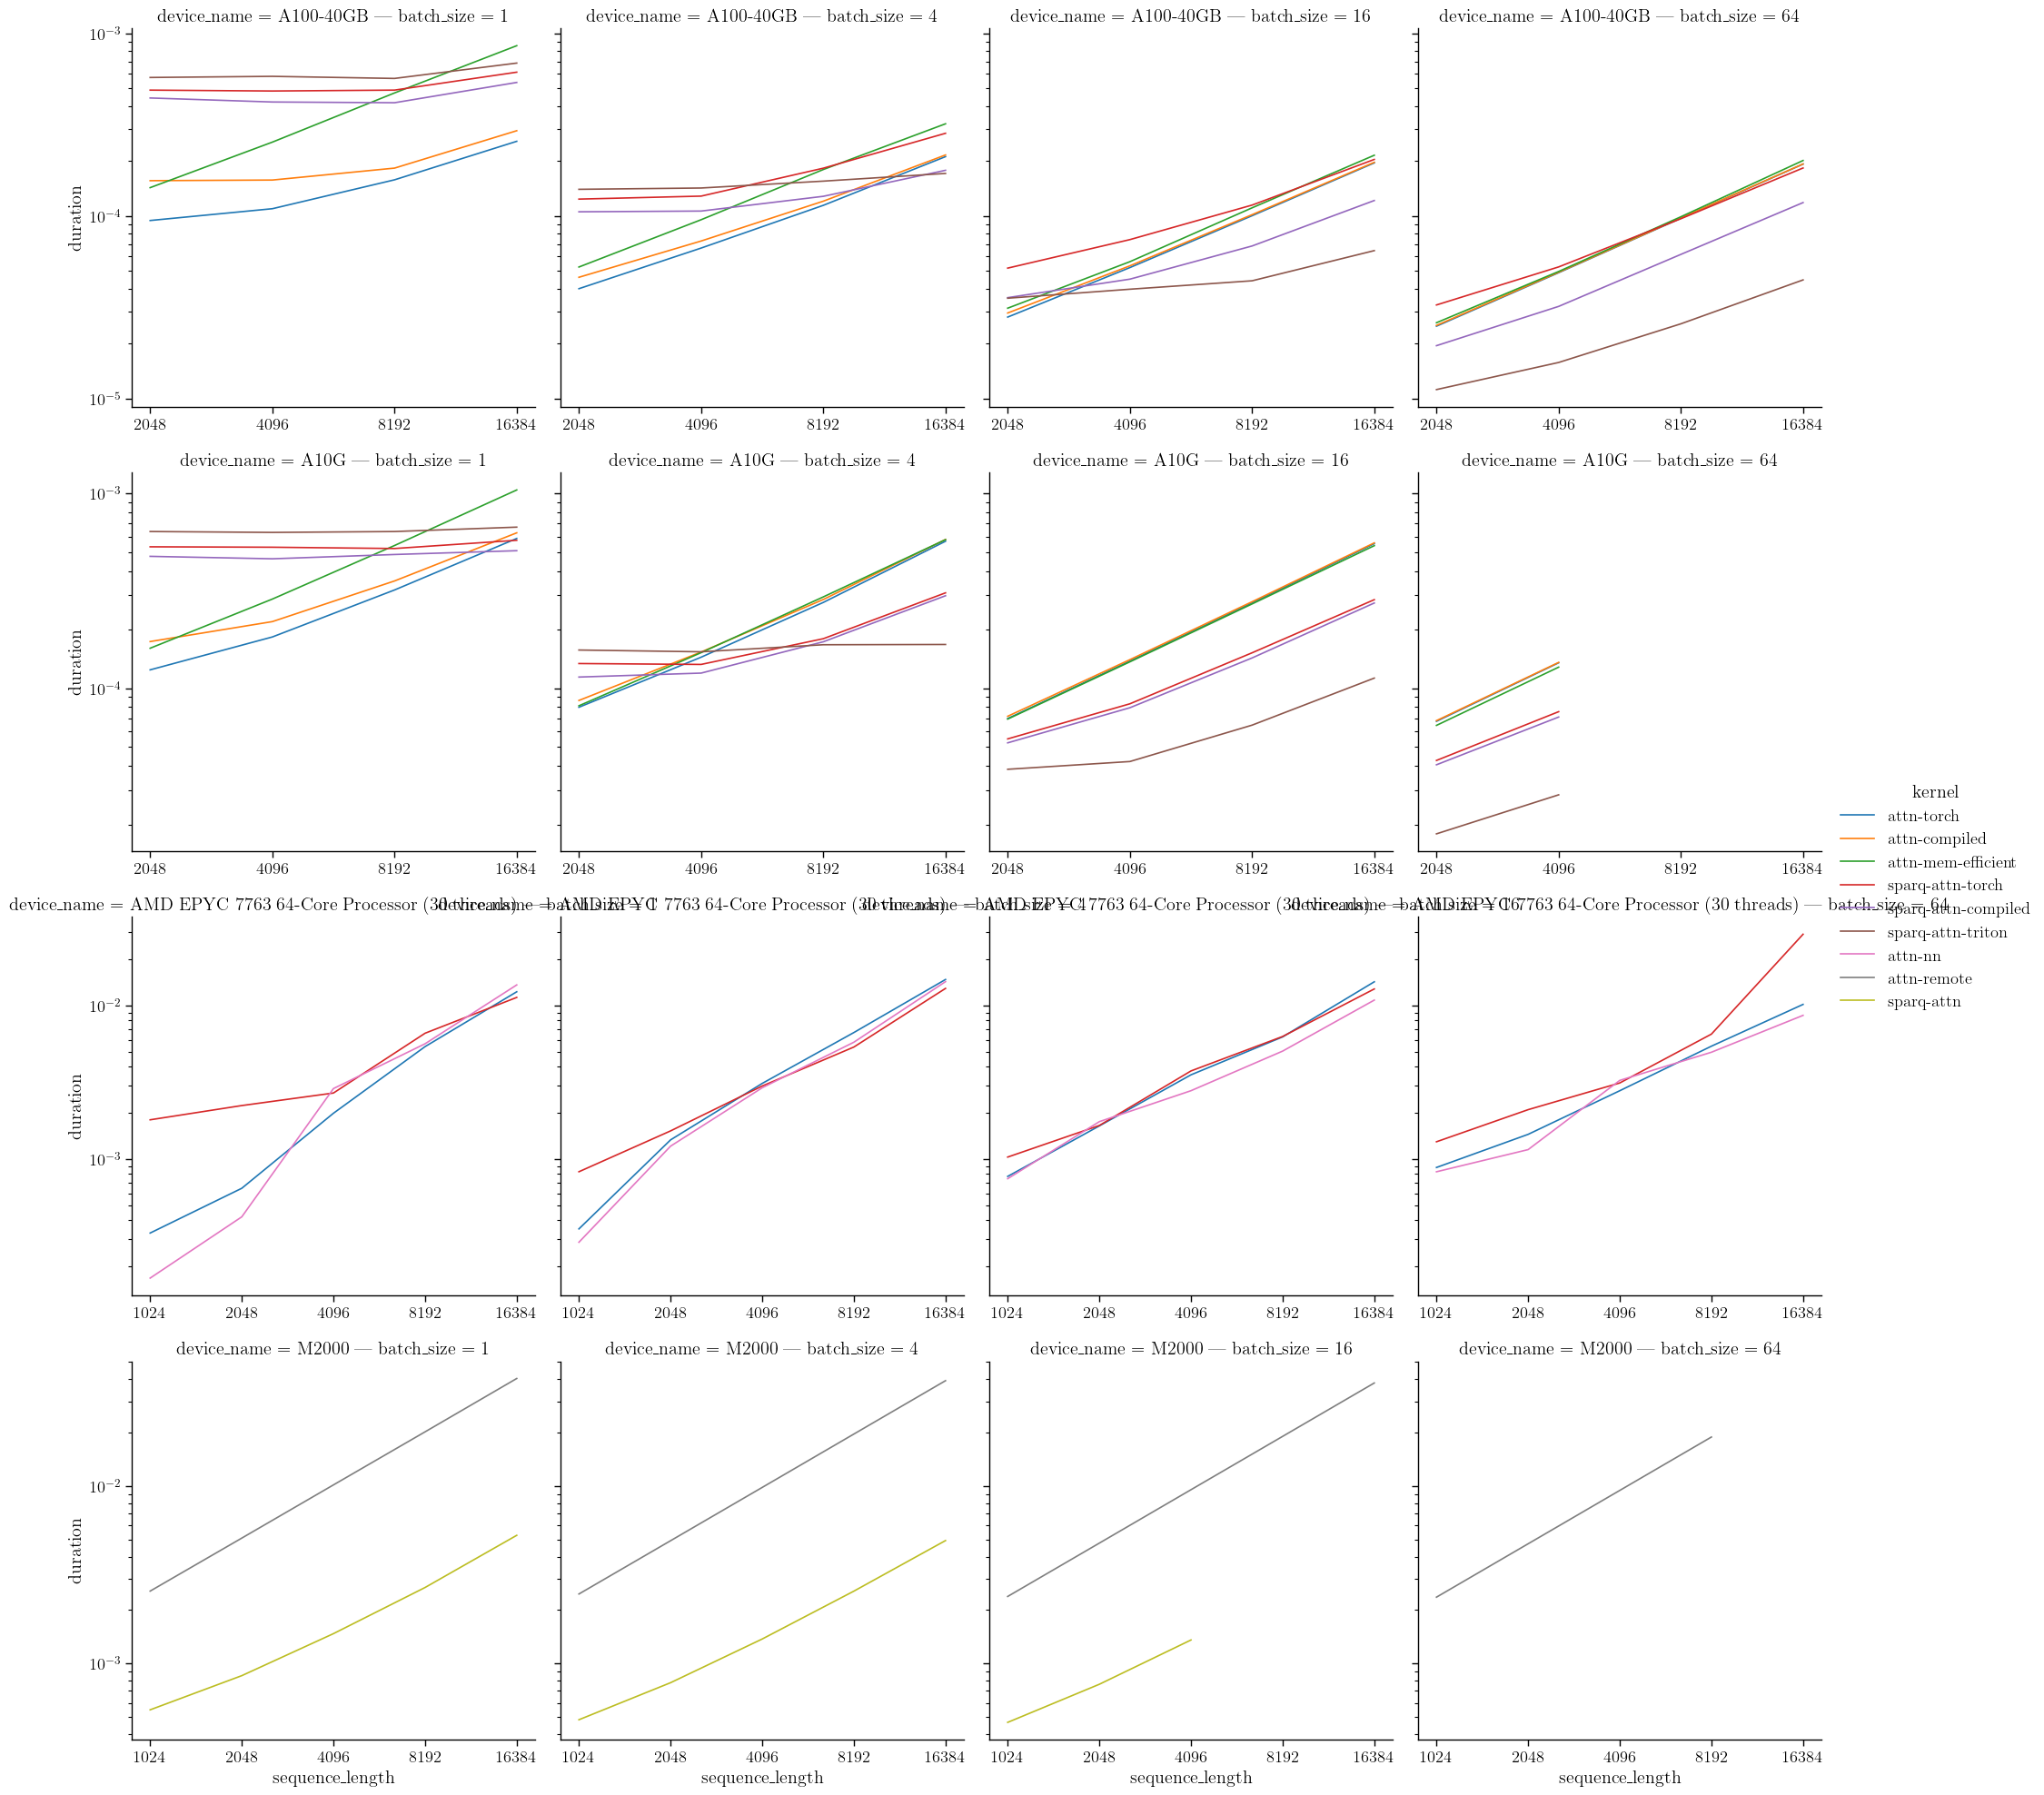

In [7]:
k1, k2 = 32, 64

g = sns.relplot(data=df.pipe(lambda d: d[d.baseline | ((d.k1==k1) & (d.k2==k2))]).pipe(lambda d: d[d.sequence_length <= 16384])
  .pipe(lambda d: d[~d.kernel.isin(["attn-flash", "attn-math", "sparq-attn-torch-oneK", "sparq-attn-compiled-oneK", "sparq-attn-triton-oneK", "attn-local"])]),
    y="duration", x="sequence_length", hue="kernel", col="batch_size",
    row="device_name", kind="line", facet_kws=dict(sharex="row", sharey="row")
)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_yscale("log")

In [8]:
# CPU results don't look very consistent

k1, k2 = 32, 64
sequence_length = 4096

display(df
    .pipe(lambda d: d[d.device == "cpu"])

    # .pipe(lambda d: d[d.kernel == "sparq-attn-torch"])
    # .pipe(lambda d: d.assign(theoretical_bytes=d.theoretical_bytes*d.batch_size))
    # # .pivot_table(index=["batch_size"], columns=["sequence_length"], values="theoretical_bytes") / 1e9
    # .pivot_table(index=["batch_size"], columns=["sequence_length"], values="duration")

    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "attn-nn"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pivot_table(index="kernel", columns="batch_size", values="duration")
    .pipe(lambda d: d*1e3)
    .style.format("{:.2f}")
)

batch_size,1,4,16,64
kernel,,,,
attn-nn,2.88,2.92,2.79,3.26
attn-torch,1.99,3.11,3.54,2.79
sparq-attn-torch,2.70,2.99,3.76,3.14
sparq-attn-torch-oneK,2.42,4.54,4.84,3.99


<Axes: xlabel='sequence_length', ylabel='k1-k2'>

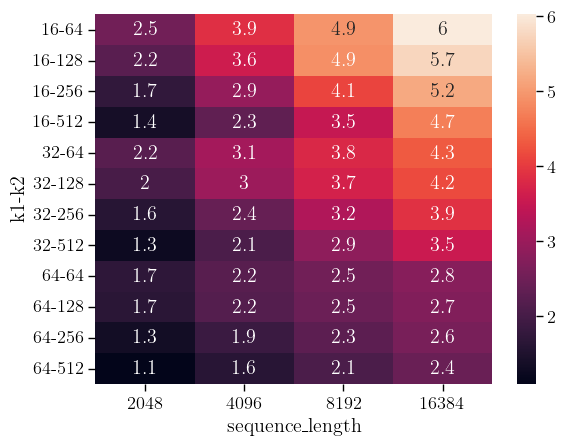

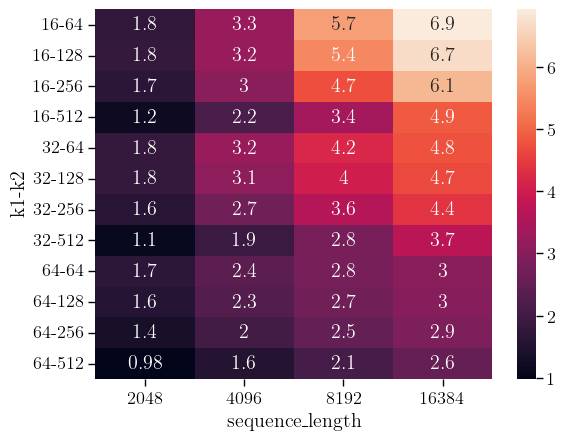

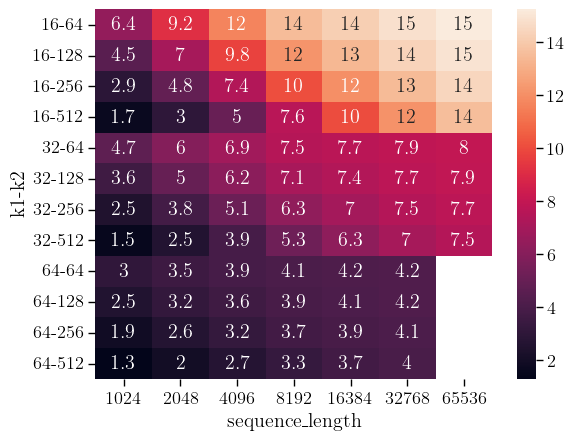

In [9]:
plt.figure()
sns.heatmap(df
 .pipe(lambda d: d[d.device_name=="A100-40GB"])
 .pipe(lambda d: d[d.batch_size==64])
 .pipe(lambda d: d[d.kernel == "sparq-attn-triton"])
 .pipe(lambda d: d.assign(k1=d.k1.apply(int), k2=d.k2.apply(int)))
 .pivot_table(index=["k1", "k2"], columns=["sequence_length"], values="speedup"),
 annot=True,
)
plt.figure()
sns.heatmap(df
 .pipe(lambda d: d[d.device_name=="A10G"])
 .pipe(lambda d: d[d.batch_size==16])
 .pipe(lambda d: d[d.kernel == "sparq-attn-triton"])
 .pipe(lambda d: d.assign(k1=d.k1.apply(int), k2=d.k2.apply(int)))
 .pivot_table(index=["k1", "k2"], columns=["sequence_length"], values="speedup"),
 annot=True,
)
plt.figure()
sns.heatmap(df
 .pipe(lambda d: d[d.device_name=="M2000"])
 .pipe(lambda d: d[d.batch_size==1])
 .pipe(lambda d: d[d.kernel == "sparq-attn"])
 .pipe(lambda d: d.assign(k1=d.k1.apply(int), k2=d.k2.apply(int)))
 .pivot_table(index=["k1", "k2"], columns=["sequence_length"], values="speedup"),
 annot=True,
)